In [2]:
import os
import random
from pathlib import Path

import albumentations as aug
import tensorflow as tf

import azureml.cityscapes as cityscapes
from azureml.models import deeplab_v3plus, unet_xception
from azureml.models.keras_segmentation.models import fcn, segnet

args_model = "fcn_8"  # "unet_xception"
args_resize = 64
args_batch = 32
args_augment = False


img_size = (args_resize, args_resize)
batch_size = args_batch
num_classes = 8

augment = None
if args_augment:
    # Image augmentation : None for no augmentation
    augment = aug.Compose(
        [
            aug.OneOf(  # Color augmentations
                [
                    aug.RandomBrightnessContrast(),
                    aug.RandomGamma(),
                    aug.RandomToneCurve(),
                ]
            ),
            aug.OneOf(  # Camera augmentations
                [
                    aug.MotionBlur(),
                    aug.GaussNoise(),
                ]
            ),
            aug.OneOf(  # Geometric augmentations
                [
                    aug.HorizontalFlip(),
                    aug.RandomCrop(
                        width=int(img_size[0] / random.uniform(1.0, 2.0)),
                        height=int(img_size[1] / random.uniform(1.0, 2.0)),
                    ),
                    aug.SafeRotate(
                        limit=15,
                    ),
                ]
            ),
            aug.Resize(
                width=img_size[0],
                height=img_size[1],
            ),
        ]
    )

# Get the model
model_name = f"{args_model}_{args_resize}{'_augment' if args_augment else ''}"
model_path = Path("./../results/", model_name)


try:
    model = tf.keras.models.load_model(
        Path(model_path, "model"),
        custom_objects={
            "UpdatedMeanIoU": cityscapes.UpdatedMeanIoU,
            "jaccard_loss": cityscapes.jaccard_loss,
        },
    )
    print(f">>> Loaded model {model_name} .")
except Exception as e:
    print(f">>> Error loading model {model_name} : {e}")
    print(f">>> Creating new model {model_name}.")

    model = None
    if args_model == "unet_xception":
        model = unet_xception.get_model(
            img_size, num_classes, model_name=model_name
        )
    elif args_model == "deeplab_v3plus":
        model = deeplab_v3plus.get_model(
            weights="cityscapes",
            input_tensor=None,
            input_shape=(args_resize, args_resize, 3),
            classes=8,
            backbone="xception",  # "mobilenetv2"
            OS=16,
            alpha=1.0,
            activation="softmax",
            model_name=model_name,
        )
    elif args_model == "fcn_8":
        model = fcn.fcn_8(
            n_classes=8,
            input_height=args_resize,
            input_width=args_resize,
            channels=3,
        )
    elif args_model == "vgg_segnet":
        model = segnet.vgg_segnet(
            n_classes=8,
            input_height=args_resize,
            input_width=args_resize,
            channels=3,
        )

model.summary()

# Configure the model for training.
model.compile(
    optimizer="adam",
    loss=cityscapes.jaccard_loss,  # "sparse_categorical_crossentropy",
    metrics=[
        cityscapes.UpdatedMeanIoU(
            name="MeanIoU", num_classes=num_classes
        ),  # https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html
    ],
)

raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")

# Train dataset
train_input_img_paths = sorted(
    Path(leftImg8bit_path, "train").glob("**/*_leftImg8bit.png")
)
train_label_ids_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_gtFine_labelIds.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_ids_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_gtFine_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)


# train model
model.fit(
    cityscapes.CityscapesGenerator(
        batch_size,
        img_size,
        train_input_img_paths,
        train_label_ids_img_paths,
        augment,
    ),
    validation_data=cityscapes.CityscapesGenerator(
        batch_size,
        img_size,
        val_input_img_paths,
        val_label_ids_img_paths,
        augment,
    ),
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            patience=2,
            factor=0.5,
            min_delta=1e-2,
            min_lr=1e-7,
            verbose=1,
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True,
            min_delta=1e-3,
            verbose=1,
        ),
        tf.keras.callbacks.TensorBoard(log_dir=Path(model_path, "./logs")),
        cityscapes.CityscapesViewerCallback(
            val_input_img_paths, val_label_colors_img_paths, img_size
        ),
    ],
)

# save model
model.save(Path(model_path, "model"))


58900480/58889256 [==============================] - 23s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                           

2022-03-09 13:00:14.403653: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.
2022-03-09 13:00:14.571522: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.
2022-03-09 13:00:48.072252: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.
2022-03-09 13:00:48.724684: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


 1/92 [..............................] - ETA: 1:07:20 - loss: 1.7537 - MeanIoU: 0.0406

2022-03-09 13:00:53.191619: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


 2/92 [..............................] - ETA: 53:29 - loss: 1.5069 - MeanIoU: 0.0931  

In [1]:
import os

from azureml.core import Model, Workspace
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()
AZURE_SUBSCRIPTION_ID = os.getenv("AZURE_SUBSCRIPTION_ID")
AZURE_RESOURCE_GROUP = os.getenv("AZURE_RESOURCE_GROUP")
AZURE_WORKSPACE_NAME = os.getenv("AZURE_WORKSPACE_NAME")


# connect to your workspace
ws = Workspace(
    subscription_id=AZURE_SUBSCRIPTION_ID,
    resource_group=AZURE_RESOURCE_GROUP,
    workspace_name=AZURE_WORKSPACE_NAME,
)


# Get the model
model_name = "deeplab-v3plus-128-augment"
resize = int(model_name.replace("_augment", "").split("_")[-1])
img_size = (resize, resize)
model_path = Path("./../results/downlad/", model_name)


model = Model(ws, model_name)

if not Path(model_path, "model").exists():
    model.download(target_dir=model_path)

import tensorflow as tf

import azureml.cityscapes as cityscapes



model = tf.keras.models.load_model(
    Path(model_path,"model/data/model"),
    custom_objects={
        "UpdatedMeanIoU": cityscapes.UpdatedMeanIoU,
        "jaccard_loss": cityscapes.jaccard_loss,
    },
)

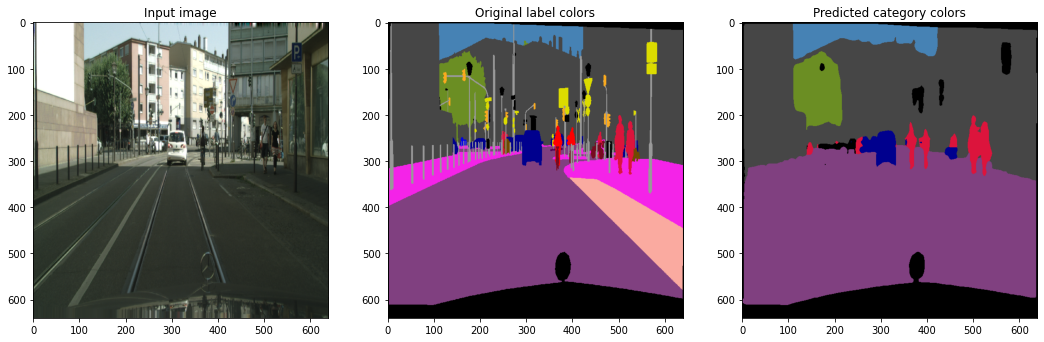

In [3]:
import base64
import numpy as np
import base64
from io import BytesIO
from PIL import Image

from matplotlib import pyplot as plt


raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")

# Train dataset
train_input_img_paths = sorted(
    Path(leftImg8bit_path, "train").glob("**/*_leftImg8bit.png")
)
train_label_ids_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_gtFine_labelIds.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_ids_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_gtFine_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)


rand_idx = np.random.randint(0, len(val_input_img_paths))


with open(val_input_img_paths[rand_idx], "rb") as f:
    im_read = f.read()
    im_b64 = base64.b64encode(im_read)
    im_b64_str = im_b64.decode("utf-8")


    Image.open(BytesIO(base64.b64decode(im_b64))).show()
    Image.open(BytesIO(base64.b64decode(im_b64_str))).show()

    im_binary = base64.b64decode(im_b64)
    im_bytes = BytesIO(im_binary)
    input_img = Image.open(im_bytes).resize(img_size)

    # input_img = tf.keras.utils.load_img(im, target_size=img_size)
    output_mask = cityscapes.cityscapes_category_ids_to_category_colors(
        np.squeeze(
            np.argmax(model.predict(np.expand_dims(input_img, 0)), axis=-1)
        )
    )

    fig, ax = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(18, 6),
    )

    ax[0].title.set_text("Input image")
    val_img = tf.keras.utils.load_img(
        val_input_img_paths[rand_idx], target_size=img_size
    )
    ax[0].imshow(val_img)

    ax[1].title.set_text("Original label colors")
    val_colors = tf.keras.utils.load_img(
        val_label_colors_img_paths[rand_idx], target_size=img_size
    )
    ax[1].imshow(val_colors)

    ax[2].title.set_text("Predicted category colors")
    ax[2].imshow(output_mask)

    plt.show()
